# Idle States Residency Analysis

In [141]:
import logging
from conf import LisaLogging
LisaLogging.setup(level=100)

In [142]:
%matplotlib inline

import os

# Support to access the remote target
from env import TestEnv

# Support to access cpuidle information from the target
from devlib import *

# Support to configure and run RTApp based workloads
from wlgen import RTA, Ramp

# Support for trace events analysis
from trace import Trace
from trace import ResidencyTime, ResidencyData

# DataFrame support
import pandas as pd
from pandas import DataFrame

# Trappy (plots) support
from trappy import ILinePlot
from trappy.stats.grammar import Parser

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# Hikey620 Platform Configurations

In [197]:
# Setup target configuration
hikey620_conf = {
    "platform"     : 'generic_linux',
    "board"        : 'hikey960',
    "results_dir"  : "test",
    "modules"      : [ 'cpufreq', 'cpuidle' ],
    "ftrace"       : {
        "events" : [ "cpu_idle", "cpu_capacity", "cpu_frequency", "sched_switch", "sched_load_avg_cpu" ],
        "buffsize" : 100 * 1024,
    },
    "tools"        : [ 'trace-cmd', 'taskset', 'rt-app', 'sysbench' ],
}

In [198]:
hikey620_platform = {
    'kernel': {
        'major': 4,
        'sha1': '78e8b90',
        'version': '57 SMP PREEMPT Sat Jul 1 15:42:00 CST 2017',
        'version_number': 4,
        'parts': [4, 4, 74],
        'rc': None,
        'release': '4.4.74-g78e8b90',
        'minor': 74
    },
    
    'freqs': {
        'big':    [ 280000, 432000, 729000, 960000, 1200000 ],
        'little': [ 280000, 432000, 729000, 960000, 1200000 ]
    },
    
    'nrg_model': {
        'big': {
            'cluster': {
                'nrg_max': 112
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 607
            }
        },
        'little': {
            'cluster': {
                'nrg_max': 112
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 607
            }
        }
    },
    
    'clusters': {
        'big': [4, 5, 6, 7],
        'little': [0, 1, 2, 3]
    },
    'cpus_count': 8,
    'topology': [[0, 1, 2, 3], [4, 5, 6, 7]]
}

# Hikey960 Platform Configurations

In [199]:
# Setup target configuration
hikey960_conf = {
    "platform"     : 'generic_linux',
    "board"        : 'hikey960',
    "results_dir"  : "test",
    "modules"      : [ 'cpufreq', 'cpuidle' ],
    "ftrace"       : {
        "events" : [ "cpu_idle", "cpu_capacity", "cpu_frequency", "sched_switch", "sched_load_avg_cpu" ],
        "buffsize" : 100 * 1024,
    },
    "tools"        : [ 'trace-cmd', 'taskset', 'rt-app', 'sysbench' ],
}

In [200]:
hikey960_platform = {
    'kernel': {
        'major': 4,
        'sha1': '78e8b90',
        'version': '57 SMP PREEMPT Sat Jul 1 15:42:00 CST 2017',
        'version_number': 14,
        'parts': [4, 14, 74],
        'rc': None,
        'release': '4.4.74-g78e8b90',
        'minor': 74
    },
    
    'freqs': {
        'big':    [ 533000,  999000, 1402000, 1709000, 1844000 ],
        'little': [ 903000, 1421000, 1805000, 2112000, 2362000 ]
    },
    
    'nrg_model': {
        'big': {
            'cluster': {
                'nrg_max': 433
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 2848
            }
        },
        'little': {
            'cluster': {
                'nrg_max': 144
            },
            'cpu': {
                'cap_max': 462,
                'nrg_max': 502
            }
        }
    },
    
    'clusters': {
        'big'    : [4, 5, 6, 7],
        'little' : [0, 1, 2, 3]
    },
    'cpus_count': 8,
    'topology': [[0, 1, 2, 3], [4, 5, 6, 7]]
}

# Idle state statistics comparison

## Plot the CPU idle state residency for two data frame in the single picture.  So it's directive for reviewing the difference between two testings. 

In [75]:
def plotCPUIdleStateResidencyComparison(prev_ia, post_ia, cpus=None, pct=False):
    if not prev_ia._trace.hasEvents('cpu_idle'):
        prev_ia._log.warning('Events [cpu_idle] not found, plot DISABLED!')
        return
    
    if not post_ia._trace.hasEvents('cpu_idle'):
        post_ia._log.warning('Events [cpu_idle] not found, plot DISABLED!')
        return
    
    if cpus is None:
        # Generate plots only for available CPUs
        cpuidle_data = prev_ia._dfg_trace_event('cpu_idle')
        _cpus = range(cpuidle_data.cpu_id.max() + 1)
    else:
        _cpus = listify(cpus)
    
    # print _cpus
    
    xmax = 0.0 
    
    prev_residencies = []
    post_residencies = []
    
    for cpu in _cpus:
        r = prev_ia._dfg_cpu_idle_state_residency(cpu)
        prev_residencies.append(ResidencyData('CPU{}'.format(cpu), r)) 

        max_time = r.max().values[0]
        if xmax < max_time:
            xmax = max_time
            
    for cpu in _cpus:
        r = post_ia._dfg_cpu_idle_state_residency(cpu)
        post_residencies.append(ResidencyData('CPU{}'.format(cpu), r)) 

        max_time = r.max().values[0]
        if xmax < max_time:
            xmax = max_time
            
    #print prev_residencies[0]
    #print post_residencies[0]
    
    n_plots = len(prev_residencies) + len(post_residencies)
    gs = gridspec.GridSpec(n_plots, 1)
    fig = plt.figure()

    for i, data in enumerate(prev_residencies):
        
        idx = i * 2
        
        prev_r = prev_residencies[i].residency
        post_r = post_residencies[i].residency
        
        #print prev_r
        #print post_r
        
        if prev_r is None:
            plt.close(fig)
            return
        
        if post_r is None:
            plt.close(fig)
            return
        
        is_first = idx == 0
        is_last  = (idx + 2) == n_plots
            
        axes = fig.add_subplot(gs[idx])

        yrange = 0.4 * max(6, len(r)) * n_plots
        
        if pct:
            duration = prev_r.time.sum()
            r_pct = prev_r.apply(lambda x: x*100/duration)
            r_pct.columns = [data.label]
            r_pct.T.plot.barh(ax=axes, stacked=True, figsize=(16, yrange))

            axes.legend(loc='lower center', ncol=7)
            axes.set_xlim(0, 100)
        else:
            prev_r.plot.barh(ax=axes, color='b',
                        legend=False, figsize=(16, yrange))

            axes.set_xlim(0, 1.05*xmax)
            axes.set_ylabel('Idle State')
            axes.set_title(data.label + ": Before Optimization")

        axes.grid(True)
        axes.set_xticklabels([])

        if is_first:
            legend_y = axes.get_ylim()[1]
            axes.annotate('Idle State Residency Time Comparison', xy=(0, legend_y),
                              xytext=(-50, 45), textcoords='offset points',
                              fontsize=18)
            
        axes = fig.add_subplot(gs[idx+1])

        yrange = 0.4 * max(6, len(r)) * n_plots
        
        if pct:
            duration = post_r.time.sum()
            r_pct = post_r.apply(lambda x: x*100/duration)
            r_pct.columns = [data.label]
            r_pct.T.plot.barh(ax=axes, stacked=True, figsize=(16, yrange))

            axes.legend(loc='lower center', ncol=7)
            axes.set_xlim(0, 100)
        else:
            post_r.plot.barh(ax=axes, color='g',
                        legend=False, figsize=(16, yrange))

            axes.set_xlim(0, 1.05*xmax)
            axes.set_ylabel('Idle State')
            axes.set_title(data.label + ": After Optimization")

        axes.grid(True)
        if is_last:
            if pct:
                axes.set_xlabel('Residency [%]')
            else:
                axes.set_xlabel('Time [s]')
        else:
            axes.set_xticklabels([])

## Print out data frame table for idle state difference

In [76]:
def dfCPUIdleStateResidencyComparison(prev_ia, post_ia):
    df = pd.DataFrame(columns=('index', 'state0', 'state1', 'state2'))

    if not prev_ia._trace.hasEvents('cpu_idle'):
        prev_ia._log.warning('Events [cpu_idle] not found, plot DISABLED!')
        return
    
    if not post_ia._trace.hasEvents('cpu_idle'):
        post_ia._log.warning('Events [cpu_idle] not found, plot DISABLED!')
        return
    
    # Generate plots only for available CPUs
    cpuidle_data = prev_ia._dfg_trace_event('cpu_idle')
    _cpus = range(cpuidle_data.cpu_id.max() + 1)
    
    xmax = 0.0 
    
    prev_residencies = []
    post_residencies = []
    
    for cpu in _cpus:
        r = prev_ia._dfg_cpu_idle_state_residency(cpu)
        prev_residencies.append(ResidencyData('CPU{}'.format(cpu), r)) 

        max_time = r.max().values[0]
        if xmax < max_time:
            xmax = max_time
            
    for cpu in _cpus:
        r = post_ia._dfg_cpu_idle_state_residency(cpu)
        post_residencies.append(ResidencyData('CPU{}'.format(cpu), r)) 

        max_time = r.max().values[0]
        if xmax < max_time:
            xmax = max_time
            
    for i, data in enumerate(prev_residencies):
        
        idx = i * 2
        
        prev_r = prev_residencies[i].residency
        post_r = post_residencies[i].residency
        diff_r = post_r - prev_r
        
        df = df.append({'index': data.label+"(orig)", 'state0': prev_r['time'][0],
                        'state1': prev_r['time'][1], 'state2': prev_r['time'][2]}, ignore_index=True)
        df = df.append({'index': data.label+"(opt)", 'state0': post_r['time'][0],
                        'state1': post_r['time'][1], 'state2': post_r['time'][2]}, ignore_index=True)
        df = df.append({'index': data.label+"(delta)", 'state0': diff_r['time'][0],
                        'state1': diff_r['time'][1], 'state2': diff_r['time'][2]}, ignore_index=True)            
    return df

# Idle state estimation statistics (Check if break residency)

In [77]:
def dfCPUIdleStateEstimationStatistics(ia, cpu, residency):
    
    #residency = residency / 1000000
    
    idle_df = ia._dfg_trace_event('cpu_idle')
    cpu_idle = idle_df[idle_df.cpu_id == cpu]

    # Generate valid idle states
    available_idles = sorted(idle_df.state.unique())
    available_idles = available_idles[1:]

    cpu_is_idle = ia._trace.getCPUActiveSignal(cpu) ^ 1
    cpu_idle = cpu_idle.join(cpu_is_idle.to_frame(name='is_idle'),
                                 how='outer')
    cpu_idle.fillna(method='ffill', inplace=True)

    idle_time = pd.DataFrame({'over_est' : 0, 'under_est' : 0, 'good_est' : 0, 'cpu' : 0}, index=available_idles)

    for i in available_idles:
        idle_state = cpu_idle.state.apply(
            lambda x: 1 if x == i else 0
        )
        #print idle_state
        idle_t = cpu_idle.is_idle * idle_state
        #print idle_t
        # Compute total time by integrating the square wave
        #print ia._trace.integrate_square_wave(idle_t)
        idle_t.iloc[-1] = 0.0

        # Compact signal to obtain only 1-0-1-0 sequences
        comp_sig = idle_t.loc[idle_t.shift() != idle_t]
        #print comp_sig
        if comp_sig.iloc[0] == 0.0:
            idle_interval = (comp_sig.iloc[2::2].index - comp_sig.iloc[1:-1:2].index)
        else:
            idle_interval = (comp_sig.iloc[1::2].index - comp_sig.iloc[:-1:2].index)
        
        idle_interval *= 1000000
        
        idle_time.at[i, 'cpu']  = cpu
        idle_time.at[i, 'over_est']  = len(idle_interval[idle_interval < residency[i]])
        idle_time.at[i, 'under_est'] = len(idle_interval[idle_interval > residency[i+1]])
        idle_time.at[i, 'good_est']  = len(idle_interval[(idle_interval >= residency[i]) & (idle_interval < residency[i+1])])          
        
    return idle_time

In [78]:
from collections import namedtuple

ResidencyTimes = namedtuple('ResidencyTimes', ['label', 'stats'])

def dfAllCPUIdleStateEstimationStatistics(ia, residency, cpus=None):

    if not ia._trace.hasEvents('cpu_idle'):
        ia._log.warning('Events [cpu_idle] not found, '
                        'plot DISABLED!')
        return

    if cpus is None:
        # Generate plots only for available CPUs
        cpuidle_data = ia._dfg_trace_event('cpu_idle')
        _cpus = range(cpuidle_data.cpu_id.max() + 1)
    else:
        _cpus = listify(cpus)

    # Generate valid idle states
    idle_df = ia._dfg_trace_event('cpu_idle')
    available_idles = sorted(idle_df.state.unique())
    available_idles = available_idles[1:]
    
    residencies = pd.DataFrame()
    total_r = pd.DataFrame({'over_est' : 0, 'under_est' : 0, 'good_est' : 0, 'cpu' : -1}, index=available_idles)
    for cpu in _cpus:
        r = dfCPUIdleStateEstimationStatistics(ia, cpu, residency)
        residencies = pd.concat([residencies, r])
        total_r['over_est']  = total_r['over_est']  + r['over_est']
        total_r['under_est'] = total_r['under_est'] + r['under_est']
        total_r['good_est']  = total_r['good_est']  + r['good_est']
        
    residencies = pd.concat([residencies, total_r])
    return residencies

In [79]:
def dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, residency):
    
    prev_df = dfAllCPUIdleStateEstimationStatistics(prev_ia, residency)
    post_df = dfAllCPUIdleStateEstimationStatistics(post_ia, residency)
    merge_df = pd.concat([prev_df, post_df], axis=1)
    est_diff = post_df - prev_df
    est_df = pd.concat([merge_df, est_diff], axis=1)
    return est_df

# Test case 1: power nightmare (Hikey620)

## Read trace data before optimization

In [80]:
res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/powernightmare/pre_opt'
trace_file = os.path.join(res_dir, "trace.dat")

In [81]:
prev_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)

In [82]:
prev_ia = prev_trace.analysis.idle

## Read trace data after optimization

In [83]:
res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/powernightmare/post_opt'
trace_file = os.path.join(res_dir, "trace.dat")

In [84]:
post_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)

In [85]:
post_ia = post_trace.analysis.idle

## Plot idle states residency comparison

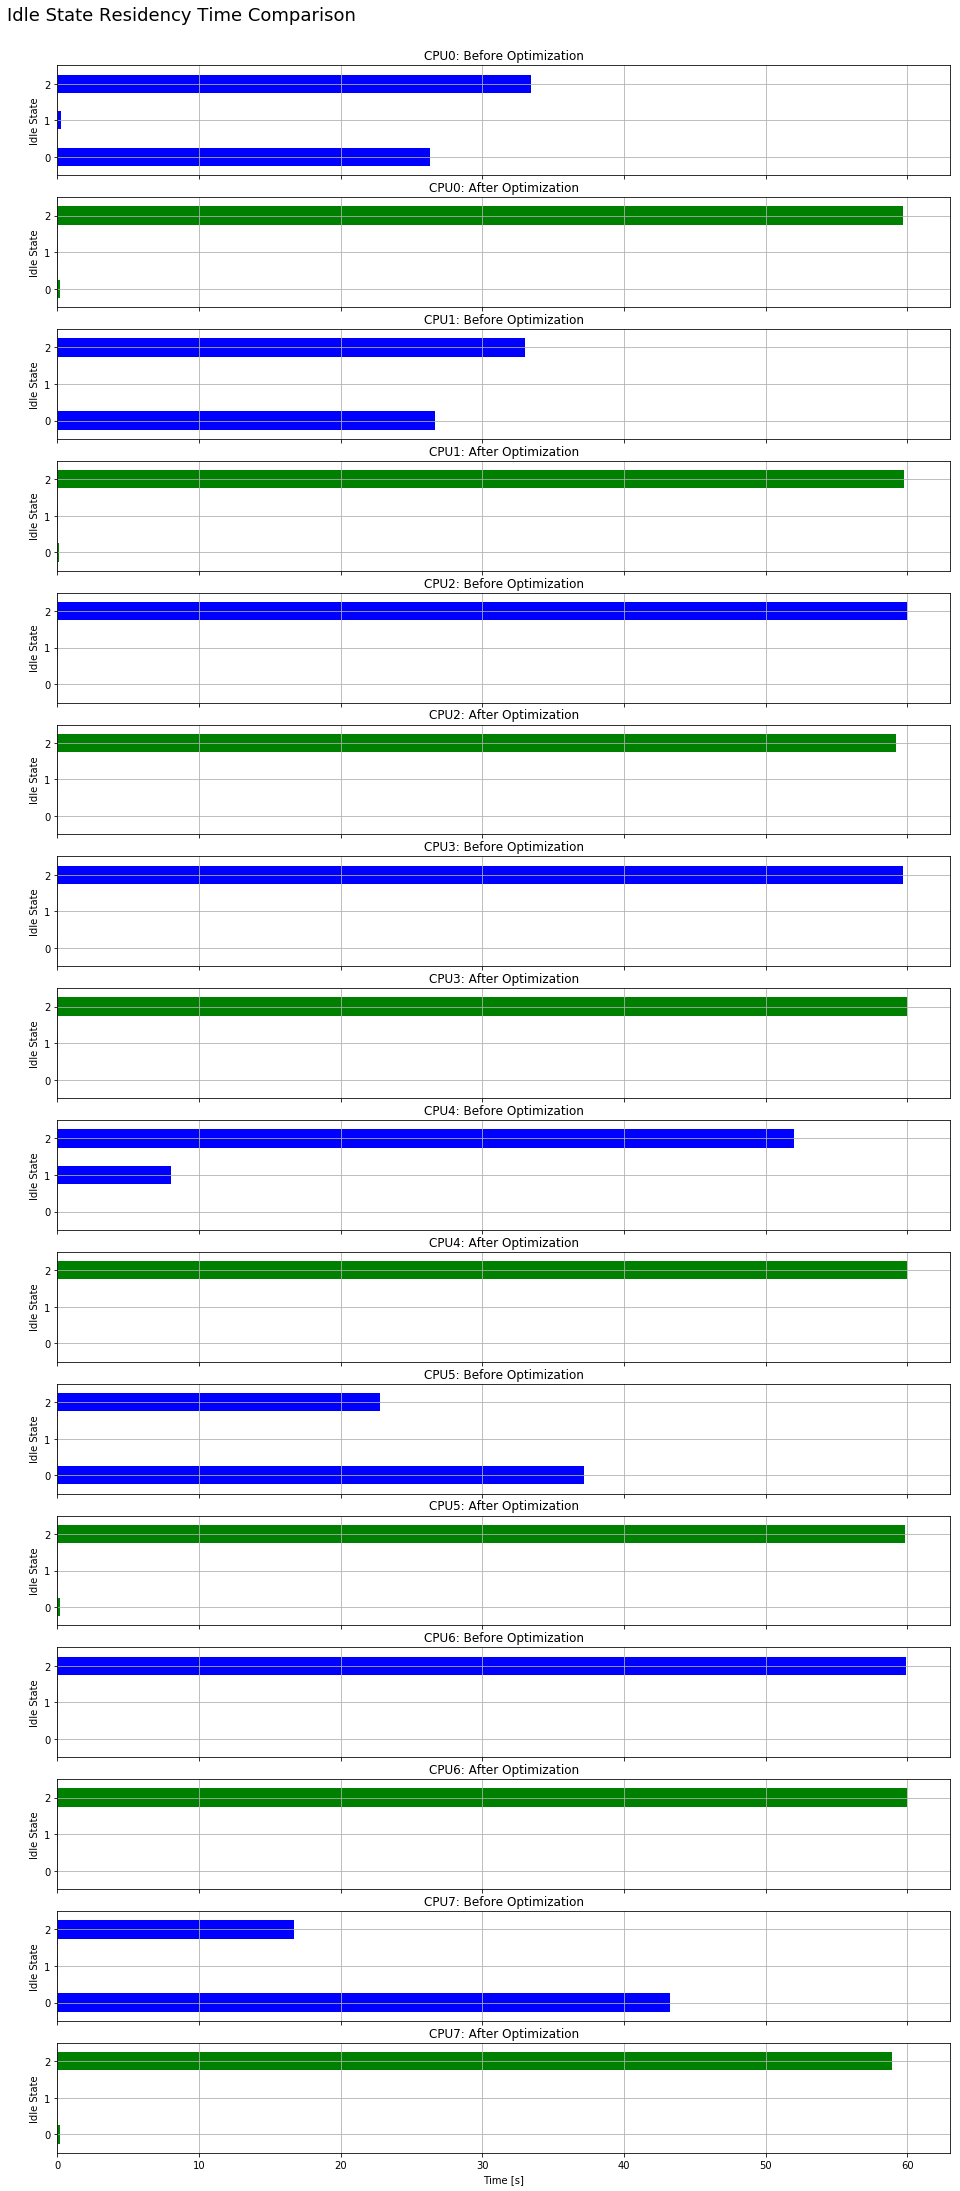

In [86]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

## Idle state residency comparison

In [87]:
df = dfCPUIdleStateResidencyComparison(prev_ia, post_ia)
df

,index,state0,state1,state2
0,CPU0(orig),26.306209,0.257640,33.437085
1,CPU0(opt),0.176018,0.073155,59.723376
2,CPU0(delta),-26.130191,-0.184485,26.286291
3,CPU1(orig),26.672985,0.000000,33.031119
4,CPU1(opt),0.142790,0.058999,59.763389
5,CPU1(delta),-26.530195,0.058999,26.732270
6,CPU2(orig),0.006951,0.038756,59.945315
7,CPU2(opt),0.007959,0.042355,59.203853
8,CPU2(delta),0.001008,0.003599,-0.741462
9,CPU3(orig),0.079421,0.000171,59.685617


## Idle state estimation statistics (break residency)

In [88]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1000, 2700, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,48,0,17,0,60,0,45,0,12,0,28
1,0,1,2,1,0,14,5,13,0,13,3,12
2,0,23,0,0,0,104,0,0,0,81,0,0
0,1,48,0,17,1,52,0,38,0,4,0,21
1,1,0,0,0,1,2,0,14,0,2,0,14
2,1,23,0,0,1,234,1,0,0,211,1,0
0,2,8,0,2,2,6,0,4,0,-2,0,2
1,2,7,2,7,2,12,5,6,0,5,3,-1
2,2,87,0,0,2,22,1,0,0,-65,1,0
0,3,0,0,2,3,11,0,1,0,11,0,-1


## Plot cluster frequency

In [89]:
prev_trace.analysis.frequency.plotClusterFrequencies()

In [90]:
post_trace.analysis.frequency.plotClusterFrequencies()

# Test case2: Android 4.14: exoplayer audio case (Hikey960)

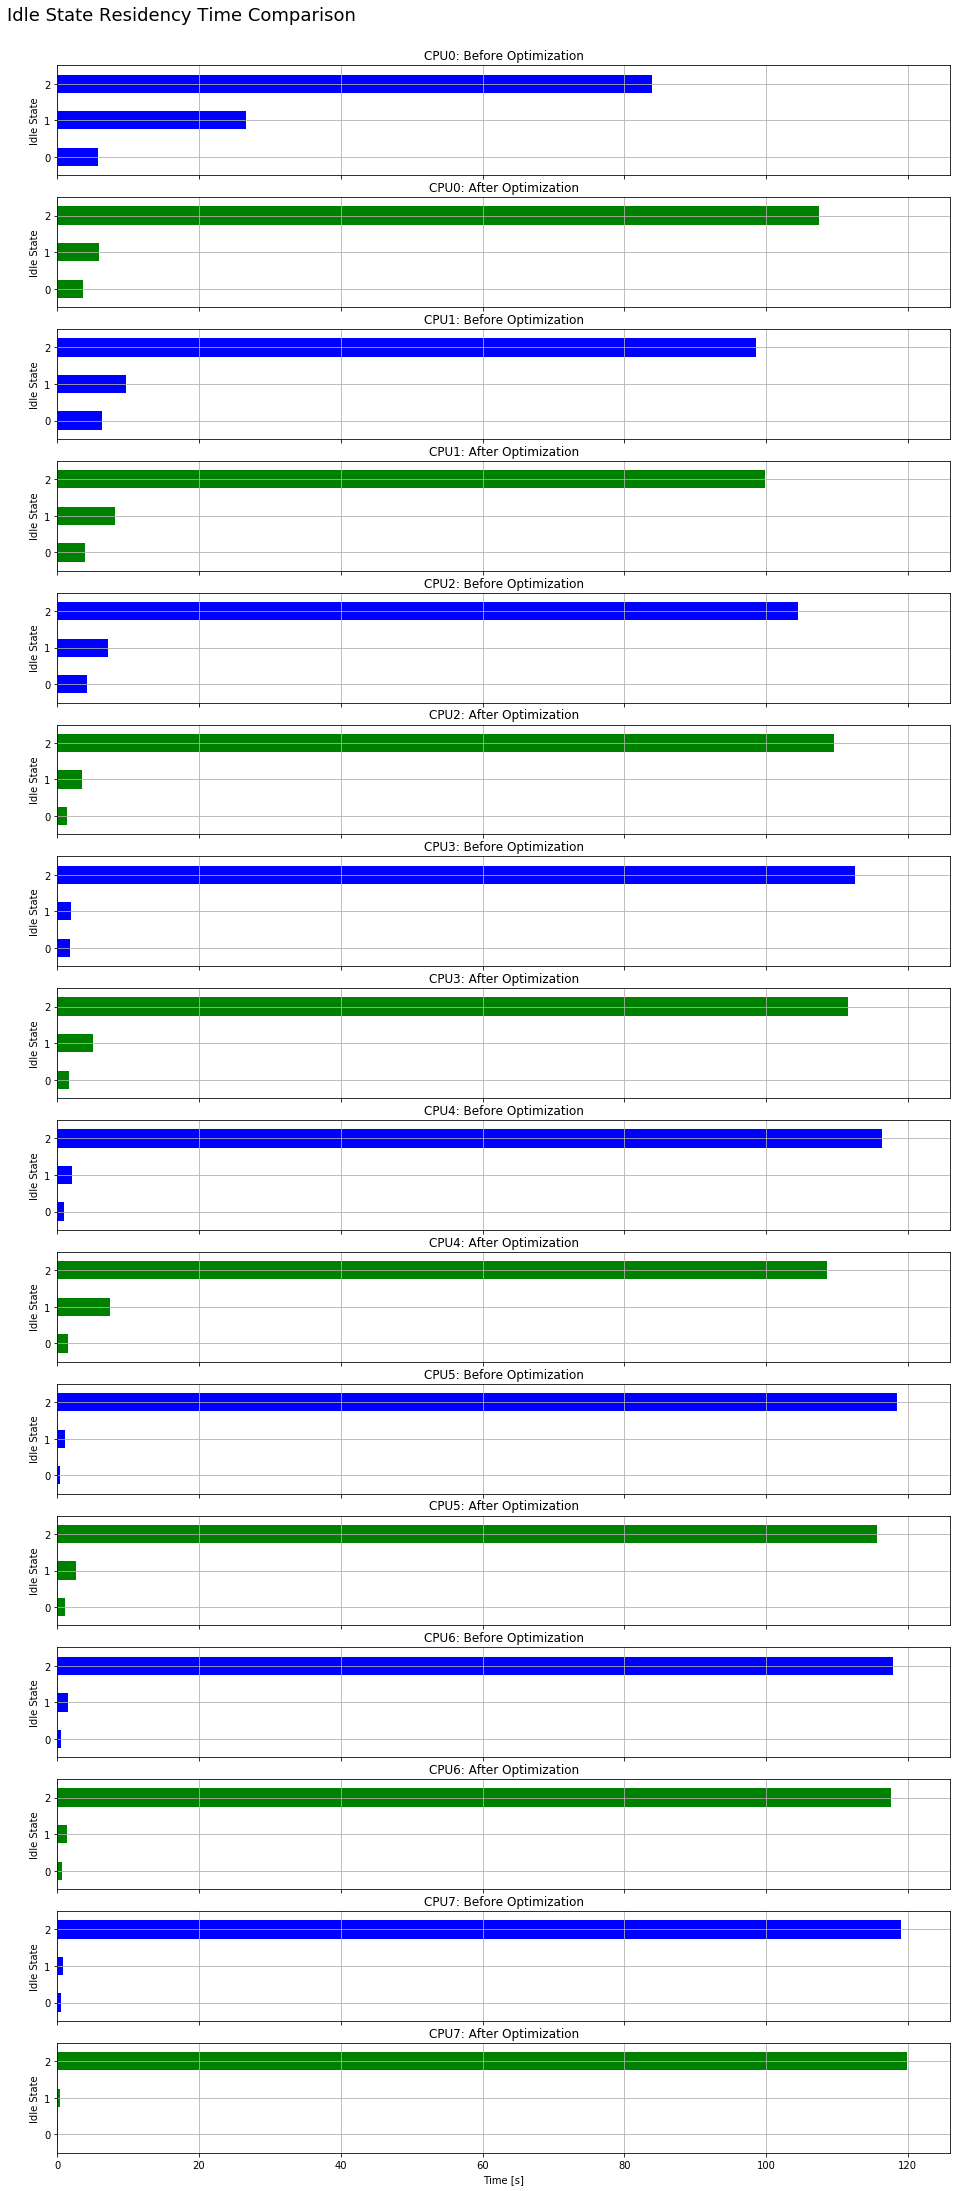

In [242]:
res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent-state2/prev_opt/audio/'
trace_file = os.path.join(res_dir, "trace.dat")

prev_trace = Trace(hikey960_platform, trace_file, events=hikey960_conf['ftrace']['events'], normalize_time=True)

prev_ia = prev_trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent-state2/post_opt/audio/'
trace_file = os.path.join(res_dir, "trace.dat")

post_trace = Trace(hikey960_platform, trace_file, events=hikey960_conf['ftrace']['events'], normalize_time=True)

post_ia = post_trace.analysis.idle

plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [243]:
df = dfCPUIdleStateResidencyComparison(prev_ia, post_ia)
df

,index,state0,state1,state2
0,CPU0(orig),5.763038,26.633492,83.968919
1,CPU0(opt),3.691568,5.898610,107.505312
2,CPU0(delta),-2.071470,-20.734882,23.536393
3,CPU1(orig),6.262182,9.648439,98.625622
4,CPU1(opt),3.986327,8.145933,99.853801
5,CPU1(delta),-2.275855,-1.502506,1.228179
6,CPU2(orig),4.190261,7.194827,104.539911
7,CPU2(opt),1.345894,3.554762,109.612473
8,CPU2(delta),-2.844367,-3.640065,5.072562
9,CPU3(orig),1.814257,1.999293,112.596117


In [244]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1500, 3500, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,7126,13,1005,0,6679,17,472,0,-447,4,-533
1,0,1132,1150,3169,0,1123,495,663,0,-9,-655,-2506
2,0,9131,3950,0,0,8996,5439,0,0,-135,1489,0
0,1,5596,1,880,1,5019,5,743,0,-577,4,-137
1,1,813,734,1355,1,1235,712,1112,0,422,-22,-243
2,1,6601,2090,0,1,9357,7444,0,0,2756,5354,0
0,2,2856,0,320,2,1466,1,256,0,-1390,1,-64
1,2,270,285,640,2,518,218,509,0,248,-67,-131
2,2,5675,1699,0,2,8748,5855,0,0,3073,4156,0
0,3,339,0,353,3,2624,3,282,0,2285,3,-71


# Plot cluster frequency

(0.9449266282310222, 0.9098944836393287)

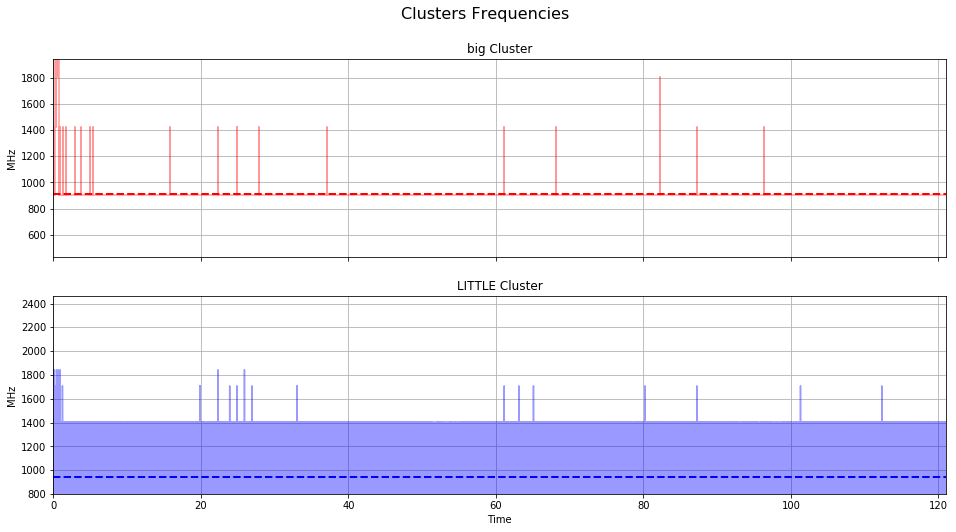

In [245]:
prev_trace.analysis.frequency.plotClusterFrequencies()

(0.9551671923486164, 0.909845110201827)

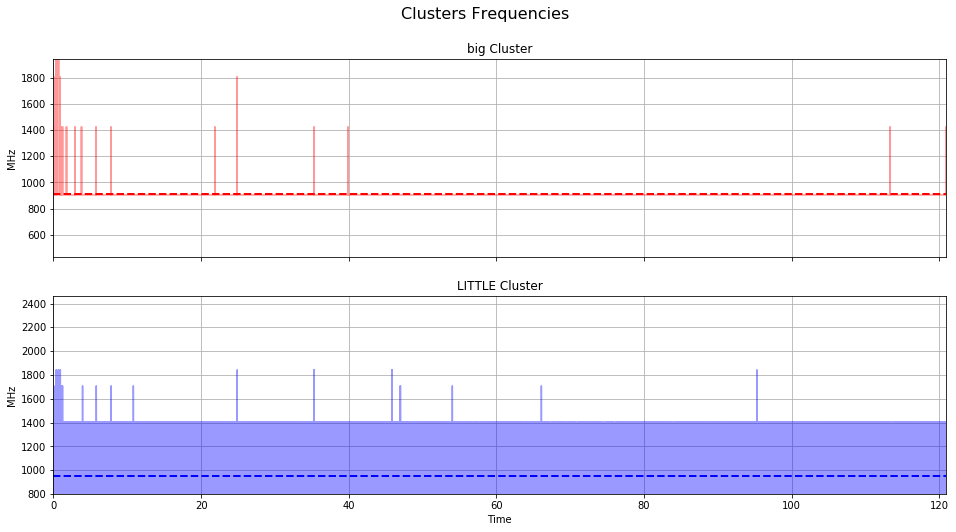

In [246]:
post_trace.analysis.frequency.plotClusterFrequencies()

## Plot CPU Utilization

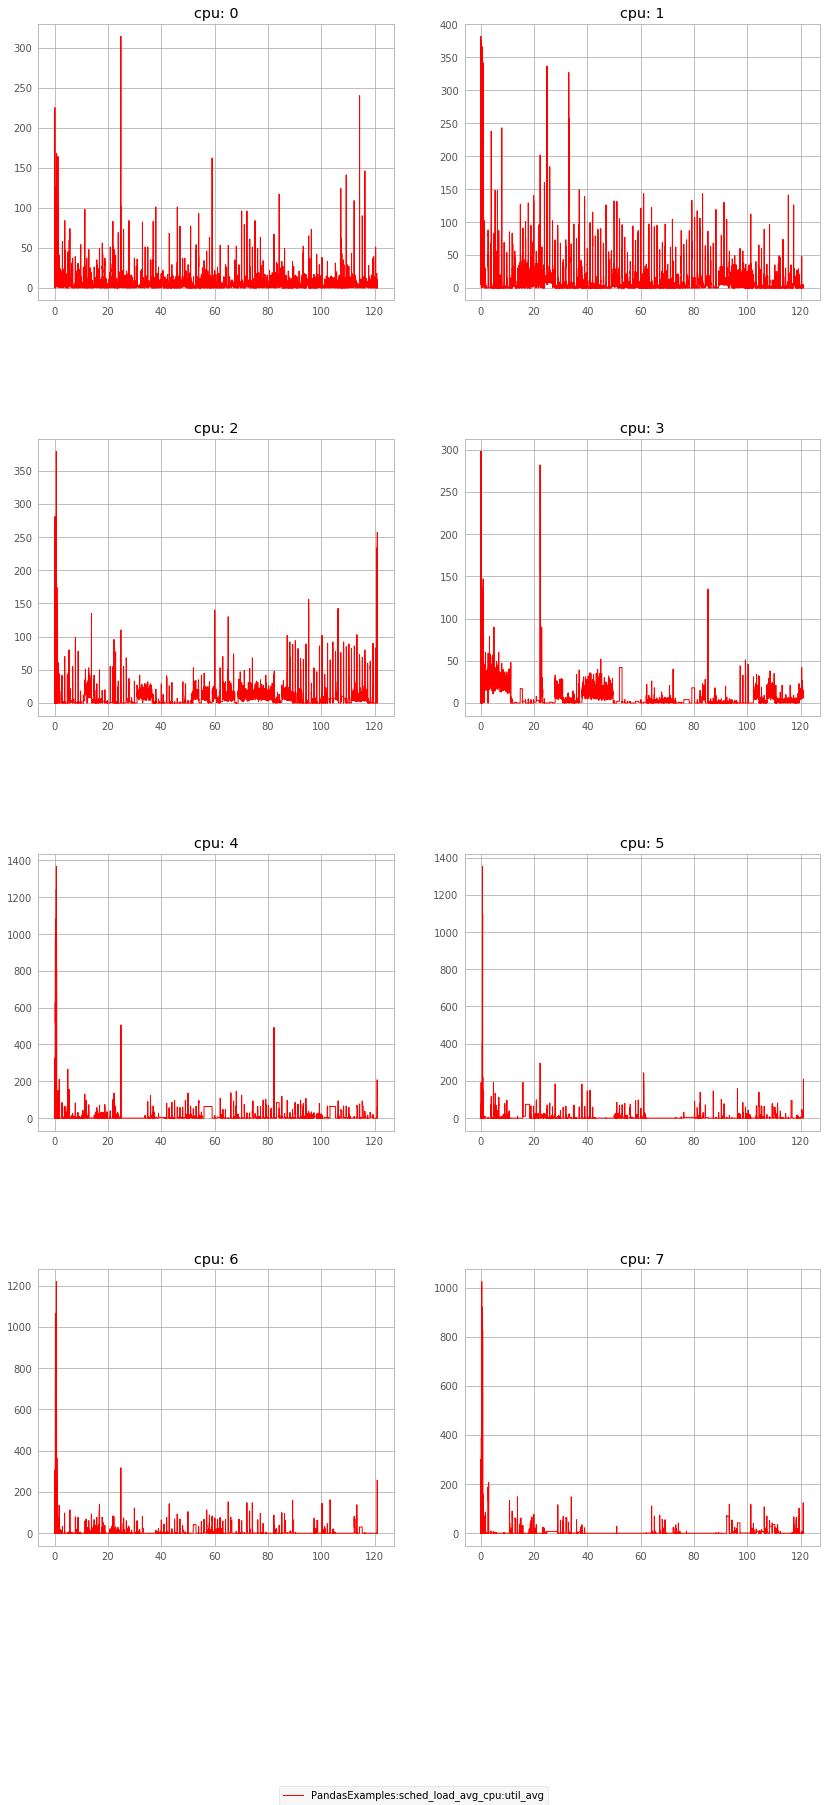

In [247]:
cpu_util_signals = [
    'sched_load_avg_cpu:util_avg',
]

res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent-state2/prev_opt/audio/'
trace_file = os.path.join(res_dir, "trace.dat")

ftrace = trappy.FTrace(
    name="PandasExamples",
    path=trace_file,
    scope='custom',
    events=['sched_load_avg_cpu'],
    window=(0,None))

trappy.LinePlot(
    ftrace,
    signals=cpu_util_signals,
    pivot='cpu',
    filters = {
        'cpu' : [0, 1, 2, 3, 4, 5, 6, 7]
    },
    drawstyle='steps-post',
).view()

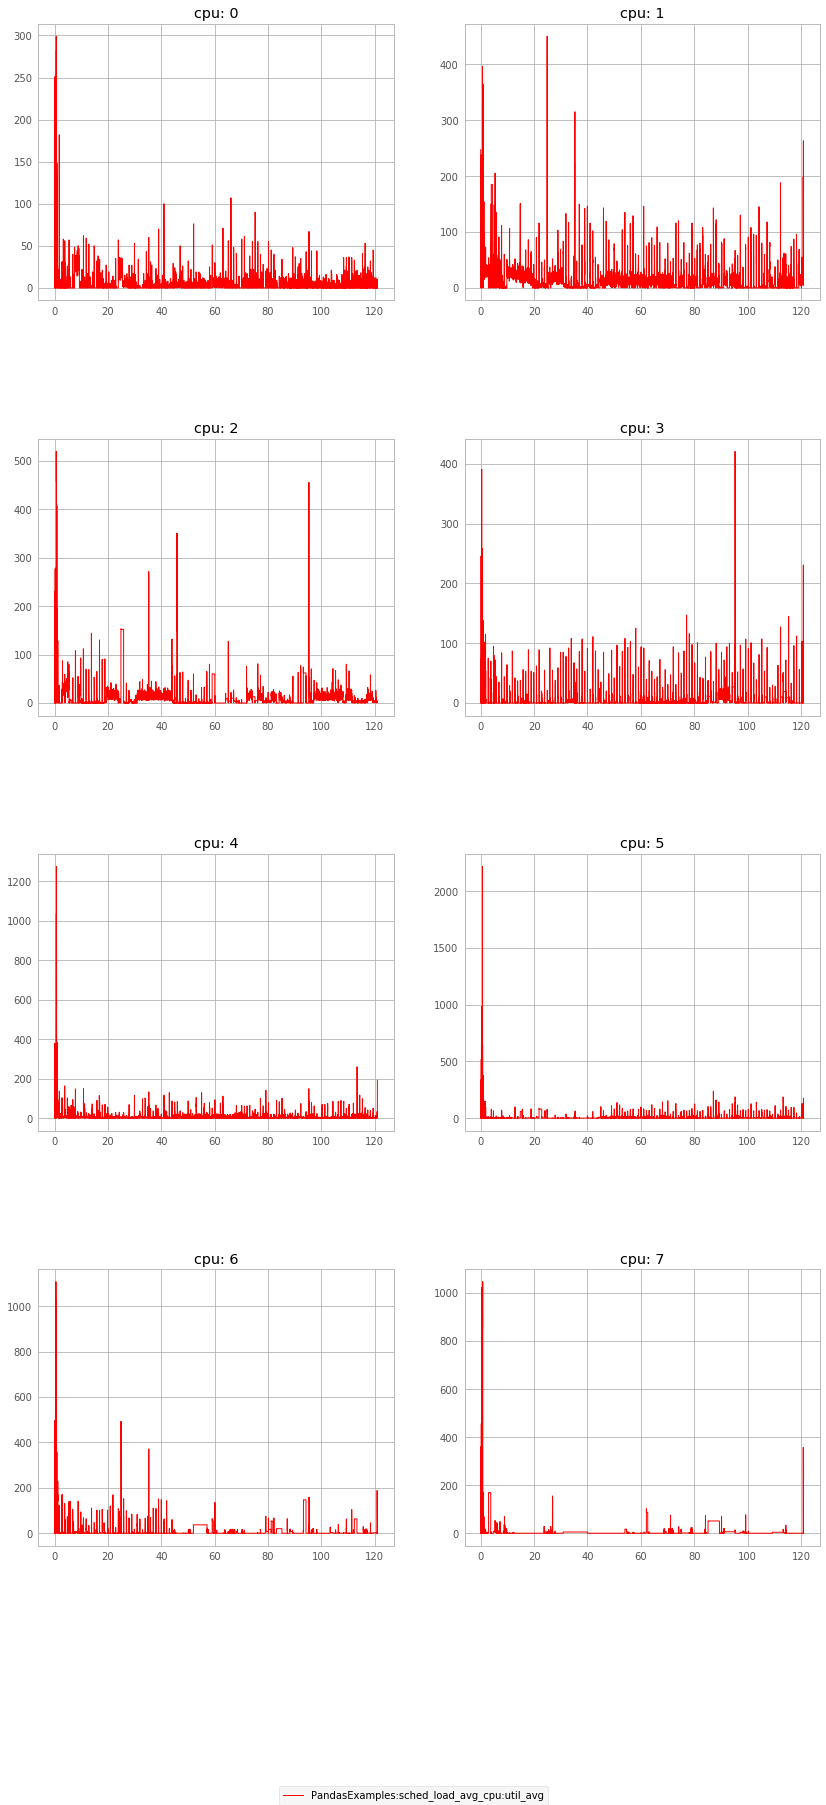

In [248]:
cpu_util_signals = [
    'sched_load_avg_cpu:util_avg',
]

res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent-state2/post_opt/audio/'
trace_file = os.path.join(res_dir, "trace.dat")

ftrace = trappy.FTrace(
    name="PandasExamples",
    path=trace_file,
    scope='custom',
    events=['sched_load_avg_cpu'],
    window=(0,None))

trappy.LinePlot(
    ftrace,
    signals=cpu_util_signals,
    pivot='cpu',
    filters = {
        'cpu' : [0, 1, 2, 3, 4, 5, 6, 7]
    },
    drawstyle='steps-post',
).view()

## CPUs activity comparison

In [249]:
df = prev_trace.analysis.cpus._dfg_context_switches()
df

,context_switch_cnt
cpu,
0,33005
1,35055
2,27431
3,25265
4,8439
5,6552
6,6854
7,4046


In [250]:
df = post_trace.analysis.cpus._dfg_context_switches()
df

,context_switch_cnt
cpu,
0,17756
1,39725
2,31294
3,14405
4,28570
5,9615
6,6079
7,1731


In [251]:
df = post_trace.analysis.cpus._dfg_context_switches() - prev_trace.analysis.cpus._dfg_context_switches()
df

,context_switch_cnt
cpu,
0,-15249
1,4670
2,3863
3,-10860
4,20131
5,3063
6,-775
7,-2315


# Test case3: Android 4.14: exoplayer video case (Hikey960)

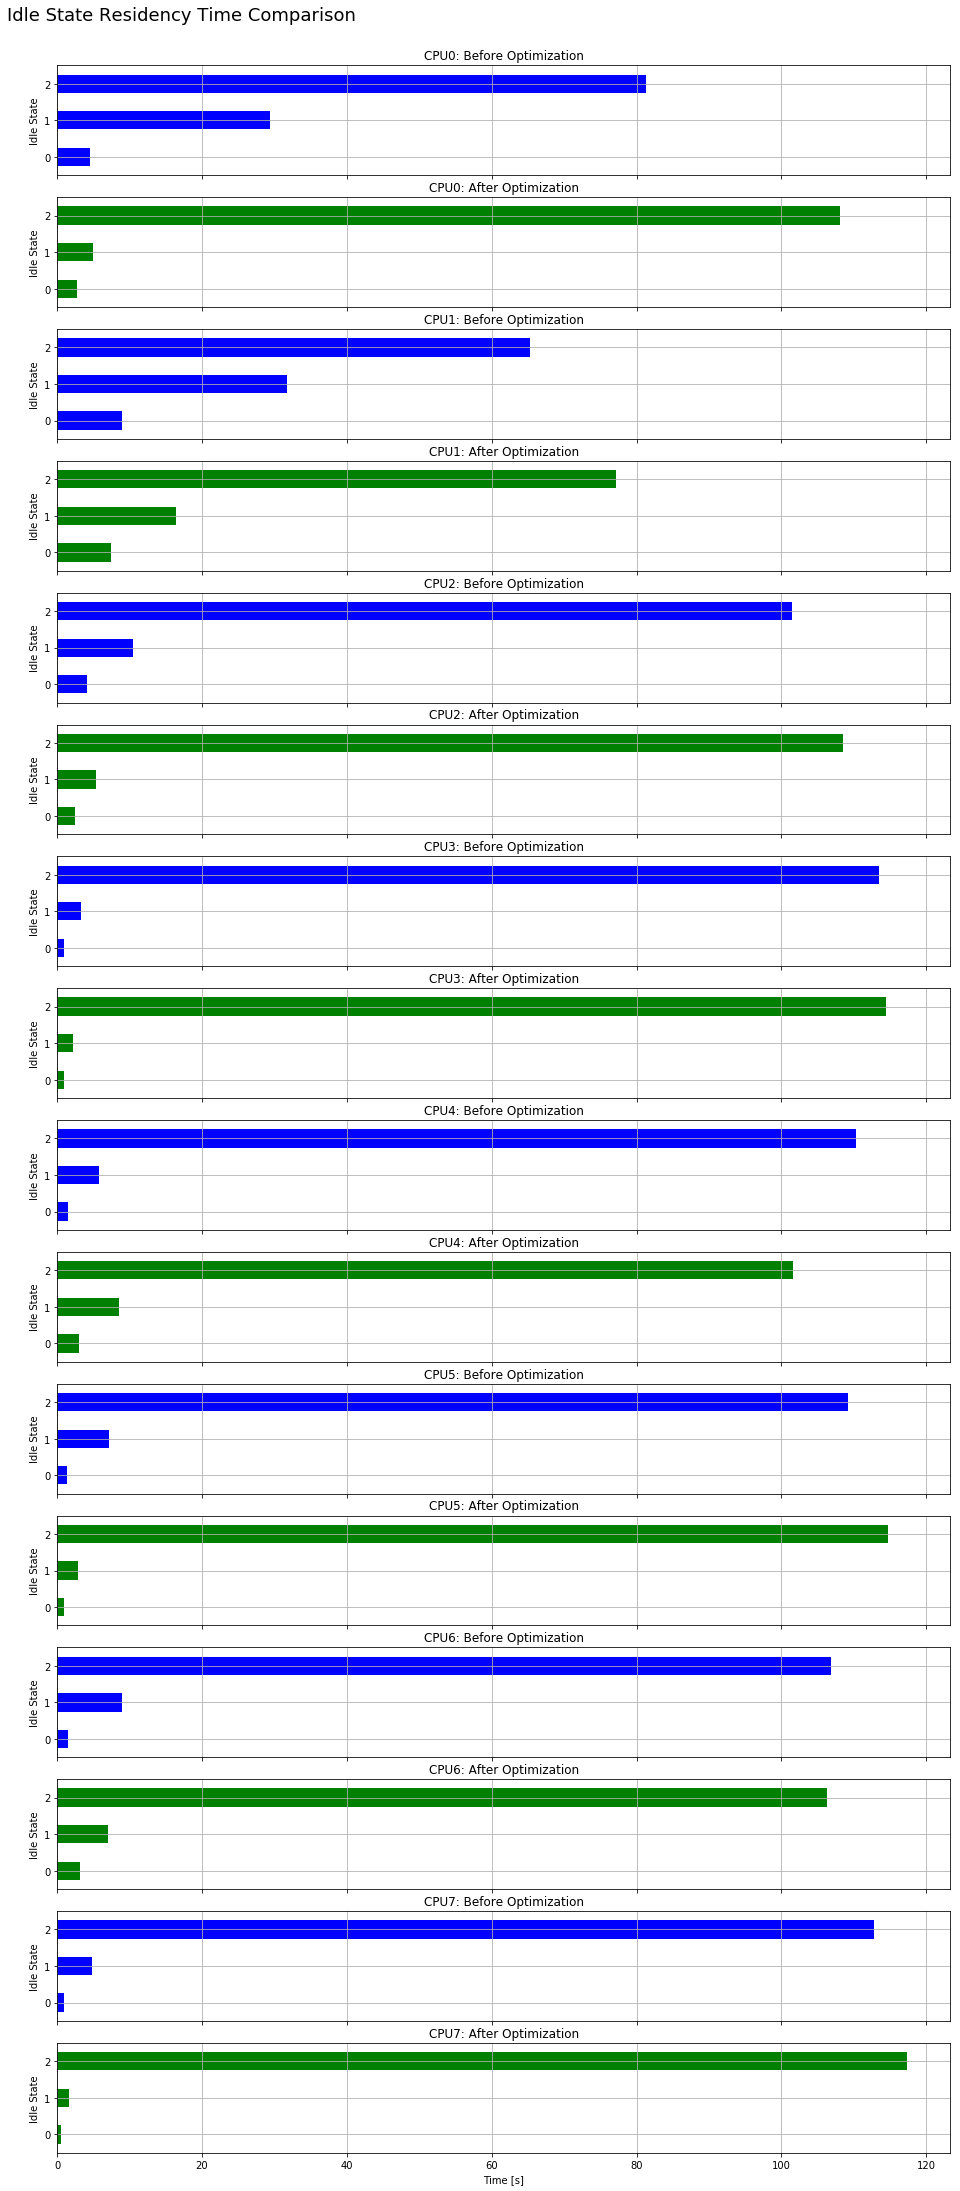

In [252]:
res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent-state2/prev_opt/video/'
trace_file = os.path.join(res_dir, "trace.dat")

prev_trace = Trace(hikey960_platform, trace_file, events=hikey960_conf['ftrace']['events'], normalize_time=True)

prev_ia = prev_trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent-state2/post_opt/video/'
trace_file = os.path.join(res_dir, "trace.dat")

post_trace = Trace(hikey960_platform, trace_file, events=hikey960_conf['ftrace']['events'], normalize_time=True)

post_ia = post_trace.analysis.idle

plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [253]:
df = dfCPUIdleStateResidencyComparison(prev_ia, post_ia)
df

,index,state0,state1,state2
0,CPU0(orig),4.532772,29.360880,81.344588
1,CPU0(opt),2.798692,4.959867,108.083540
2,CPU0(delta),-1.734080,-24.401013,26.738952
3,CPU1(orig),8.981622,31.752509,65.266204
4,CPU1(opt),7.487549,16.442932,77.196311
5,CPU1(delta),-1.494073,-15.309577,11.930107
6,CPU2(orig),4.142876,10.515758,101.455001
7,CPU2(opt),2.449707,5.291680,108.543294
8,CPU2(delta),-1.693169,-5.224078,7.088293
9,CPU3(orig),0.895216,3.261008,113.483184


In [254]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1500, 3500, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,5442,40,802,0,5565,53,379,0,123,13,-423
1,0,1195,1343,3388,0,936,614,555,0,-259,-729,-2833
2,0,8943,4723,0,0,9008,5988,0,0,65,1265,0
0,1,8964,9,1375,1,10391,7,1232,0,1427,-2,-143
1,1,1591,2963,3586,1,2720,1543,2056,0,1129,-1420,-1530
2,1,6918,4817,0,1,9655,12040,0,0,2737,7223,0
0,2,2565,1,352,2,4603,3,334,0,2038,2,-18
1,2,431,497,1225,2,402,297,988,0,-29,-200,-237
2,2,5784,2132,0,2,4940,3127,0,0,-844,995,0
0,3,940,2,166,3,1245,0,147,0,305,-2,-19


## Plot cluster frequency

(0.97285155266006, 0.913727615996386)

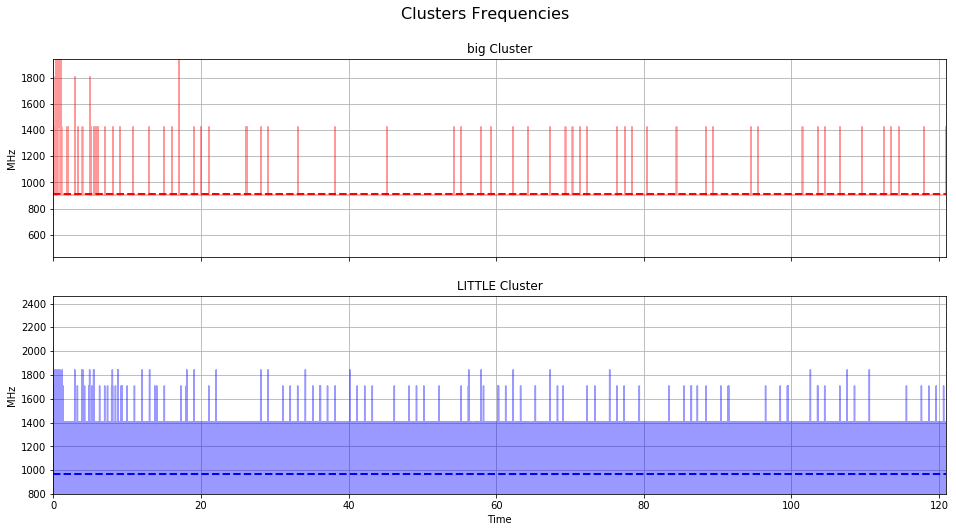

In [255]:
prev_trace.analysis.frequency.plotClusterFrequencies()

(0.9771044712274195, 0.914108586457725)

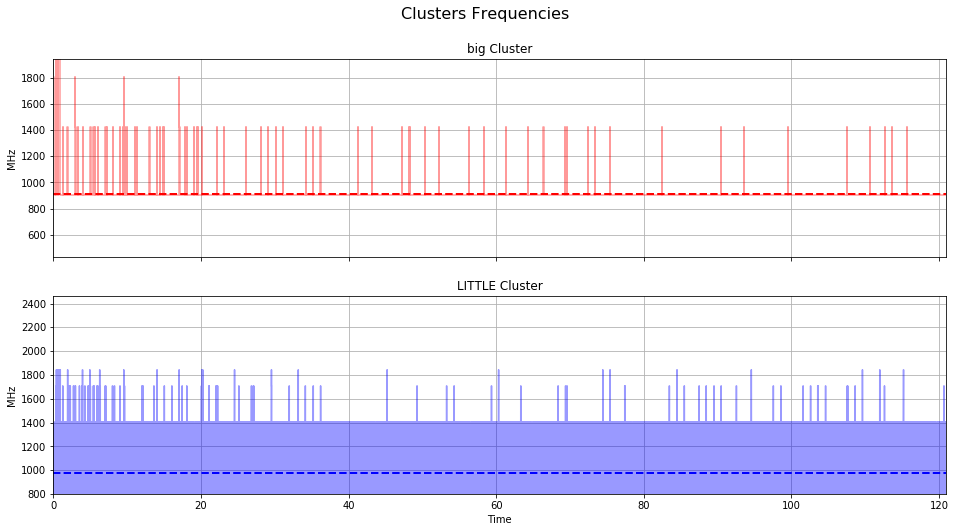

In [256]:
post_trace.analysis.frequency.plotClusterFrequencies()

## Plot CPU Utilization

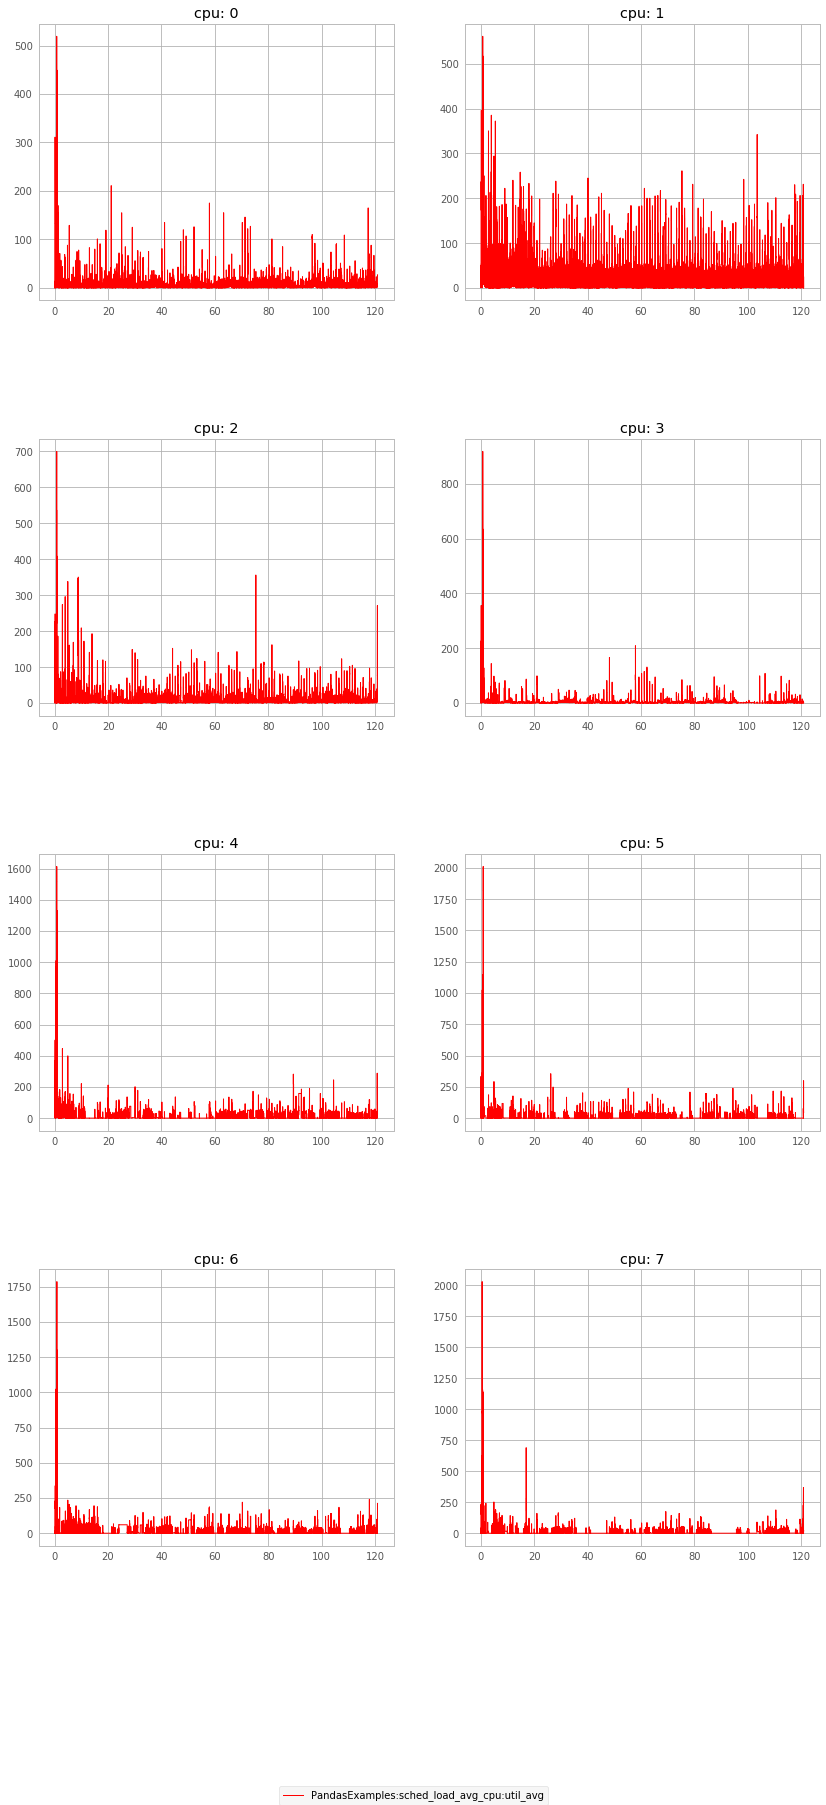

In [257]:
cpu_util_signals = [
    'sched_load_avg_cpu:util_avg',
]

res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent-state2/prev_opt/video/'
trace_file = os.path.join(res_dir, "trace.dat")

ftrace = trappy.FTrace(
    name="PandasExamples",
    path=trace_file,
    scope='custom',
    events=['sched_load_avg_cpu'],
    window=(0,None))

trappy.LinePlot(
    ftrace,
    signals=cpu_util_signals,
    pivot='cpu',
    filters = {
        'cpu' : [0, 1, 2, 3, 4, 5, 6, 7]
    },
    drawstyle='steps-post',
).view()

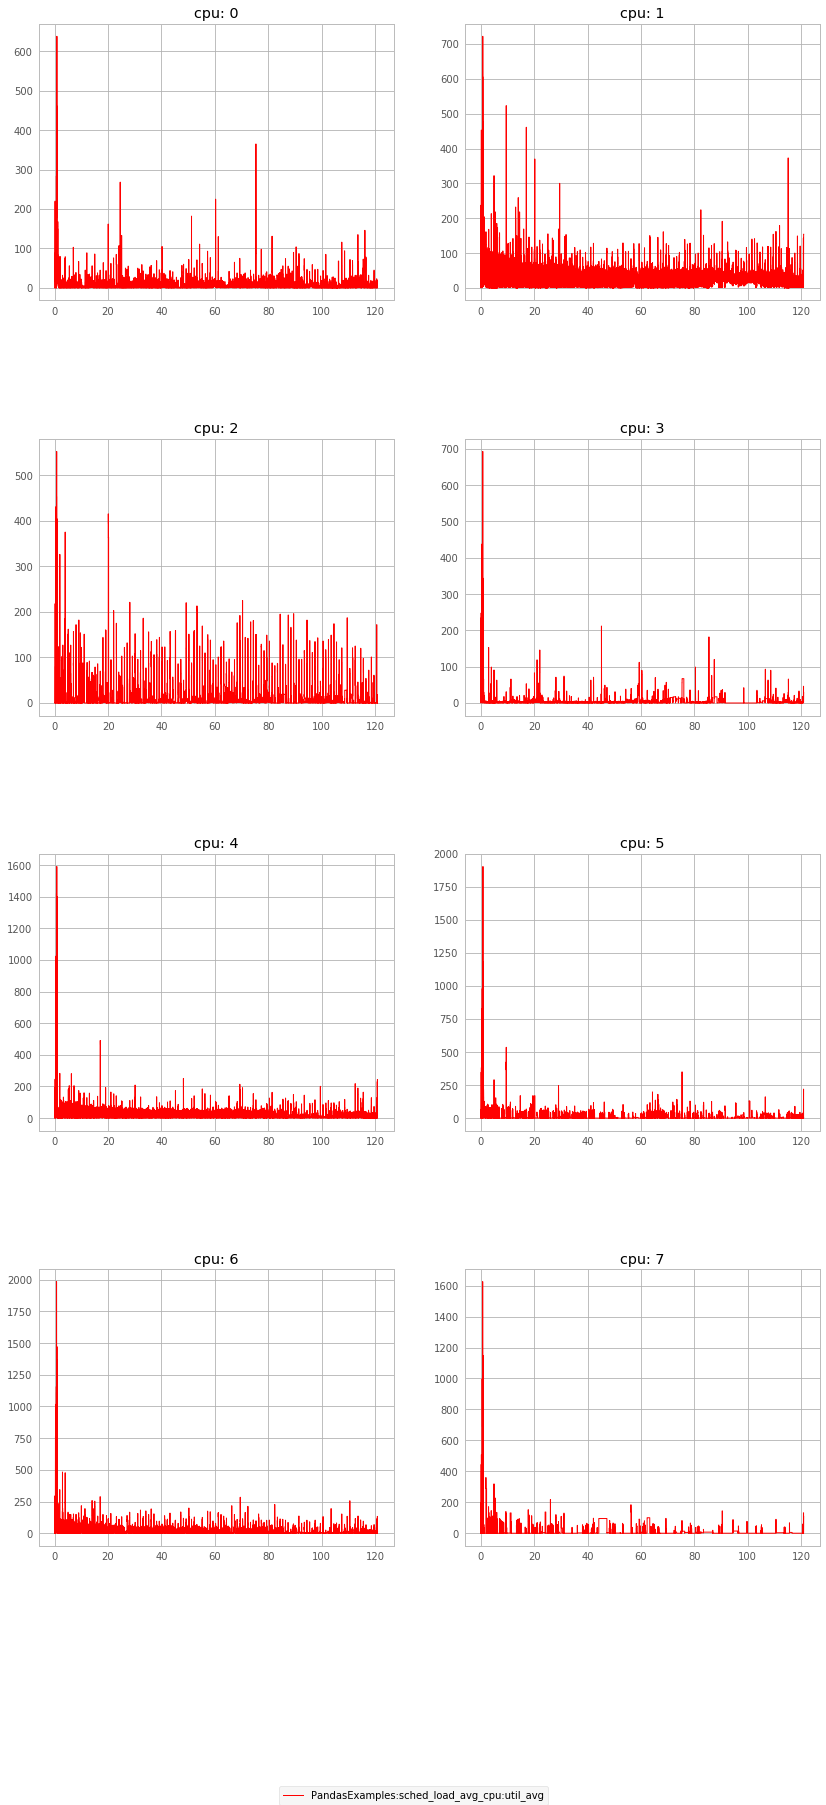

In [258]:
cpu_util_signals = [
    'sched_load_avg_cpu:util_avg',
]

res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent-state2/post_opt/video/'
trace_file = os.path.join(res_dir, "trace.dat")

ftrace = trappy.FTrace(
    name="PandasExamples",
    path=trace_file,
    scope='custom',
    events=['sched_load_avg_cpu'],
    window=(0,None))

trappy.LinePlot(
    ftrace,
    signals=cpu_util_signals,
    pivot='cpu',
    filters = {
        'cpu' : [0, 1, 2, 3, 4, 5, 6, 7]
    },
    drawstyle='steps-post',
).view()

## CPUs activity comparison

In [259]:
df = prev_trace.analysis.cpus._dfg_context_switches()
df

,context_switch_cnt
cpu,
0,32263
1,62606
2,25903
3,19071
4,14625
5,14254
6,15307
7,9177


In [260]:
df = post_trace.analysis.cpus._dfg_context_switches()
df

,context_switch_cnt
cpu,
0,15708
1,77029
2,16531
3,14675
4,36277
5,8839
6,20487
7,5124


In [261]:
df = post_trace.analysis.cpus._dfg_context_switches() - prev_trace.analysis.cpus._dfg_context_switches()
df

,context_switch_cnt
cpu,
0,-16555
1,14423
2,-9372
3,-4396
4,21652
5,-5415
6,5180
7,-4053


# Test case4: Android 4.14: homescreen (Hikey960)

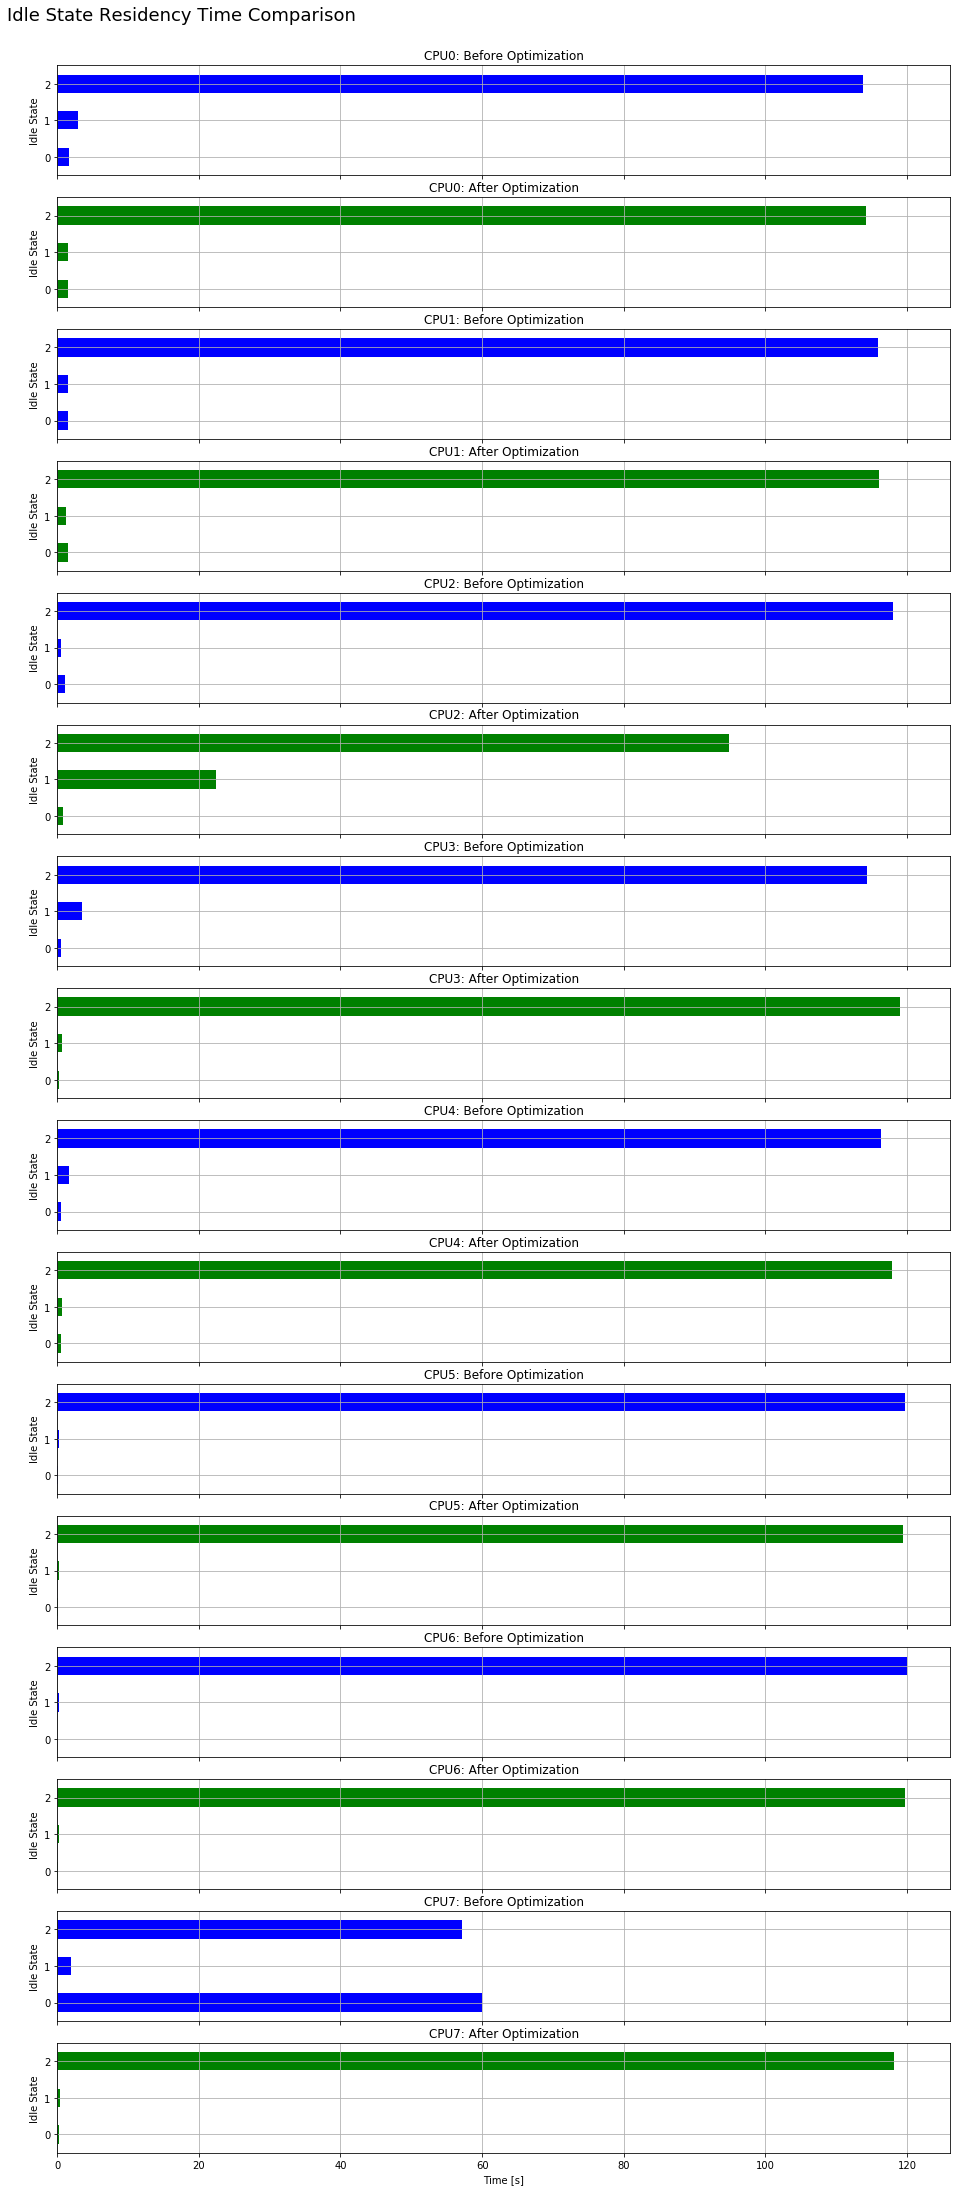

In [262]:
res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent-state2/prev_opt/homescreen/'
trace_file = os.path.join(res_dir, "trace.dat")

prev_trace = Trace(hikey960_platform, trace_file, events=hikey960_conf['ftrace']['events'])

prev_ia = prev_trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent-state2/post_opt/homescreen/'
trace_file = os.path.join(res_dir, "trace.dat")

post_trace = Trace(hikey960_platform, trace_file, events=hikey960_conf['ftrace']['events'])

post_ia = post_trace.analysis.idle

plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [263]:
df = dfCPUIdleStateResidencyComparison(prev_ia, post_ia)
df

,index,state0,state1,state2
0,CPU0(orig),1.674794,2.922923,113.766646
1,CPU0(opt),1.464086,1.575972,114.220306
2,CPU0(delta),-0.210708,-1.346951,0.453660
3,CPU1(orig),1.556793,1.571361,115.878778
4,CPU1(opt),1.583954,1.243495,116.023988
5,CPU1(delta),0.027161,-0.327866,0.145210
6,CPU2(orig),1.145572,0.481486,118.052998
7,CPU2(opt),0.830633,22.384845,94.828930
8,CPU2(delta),-0.314939,21.903359,-23.224068
9,CPU3(orig),0.551701,3.522887,114.410488


In [264]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1500, 3500, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,3641,3,109,0,1576,0,351,0,-2065,-3,242
1,0,139,159,315,0,192,356,226,0,53,197,-89
2,0,7361,1002,0,0,7435,975,0,0,74,-27,0
0,1,2427,1,95,1,4097,2,91,0,1670,1,-4
1,1,61,93,212,1,147,92,196,0,86,-1,-16
2,1,642,363,0,1,707,653,0,0,65,290,0
0,2,2251,2,36,2,2123,0,54,0,-128,-2,18
1,2,24,20,56,2,895,58,5091,0,871,38,5035
2,2,635,259,0,2,2373,549,0,0,1738,290,0
0,3,618,0,121,3,436,0,36,0,-182,0,-85


# Plot cluster frequency

(0.5788953258829285, 0.9065230358920647)

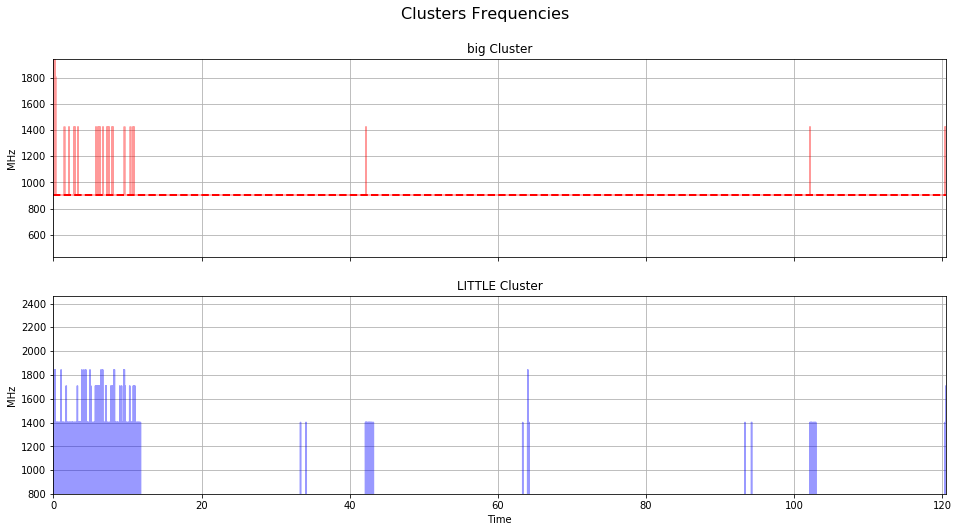

In [265]:
prev_trace.analysis.frequency.plotClusterFrequencies()

(0.5755509874713355, 0.9070064543543938)

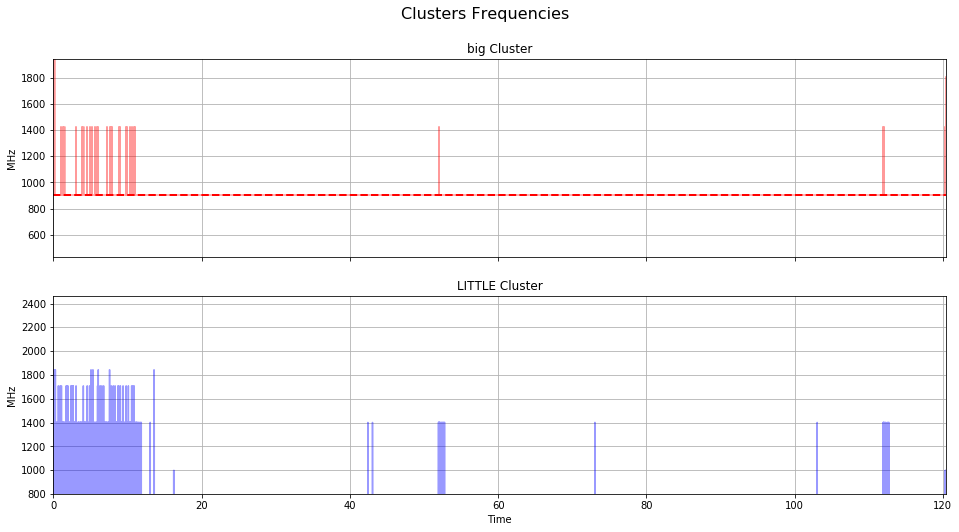

In [266]:
post_trace.analysis.frequency.plotClusterFrequencies()

## Plot CPU Utilization

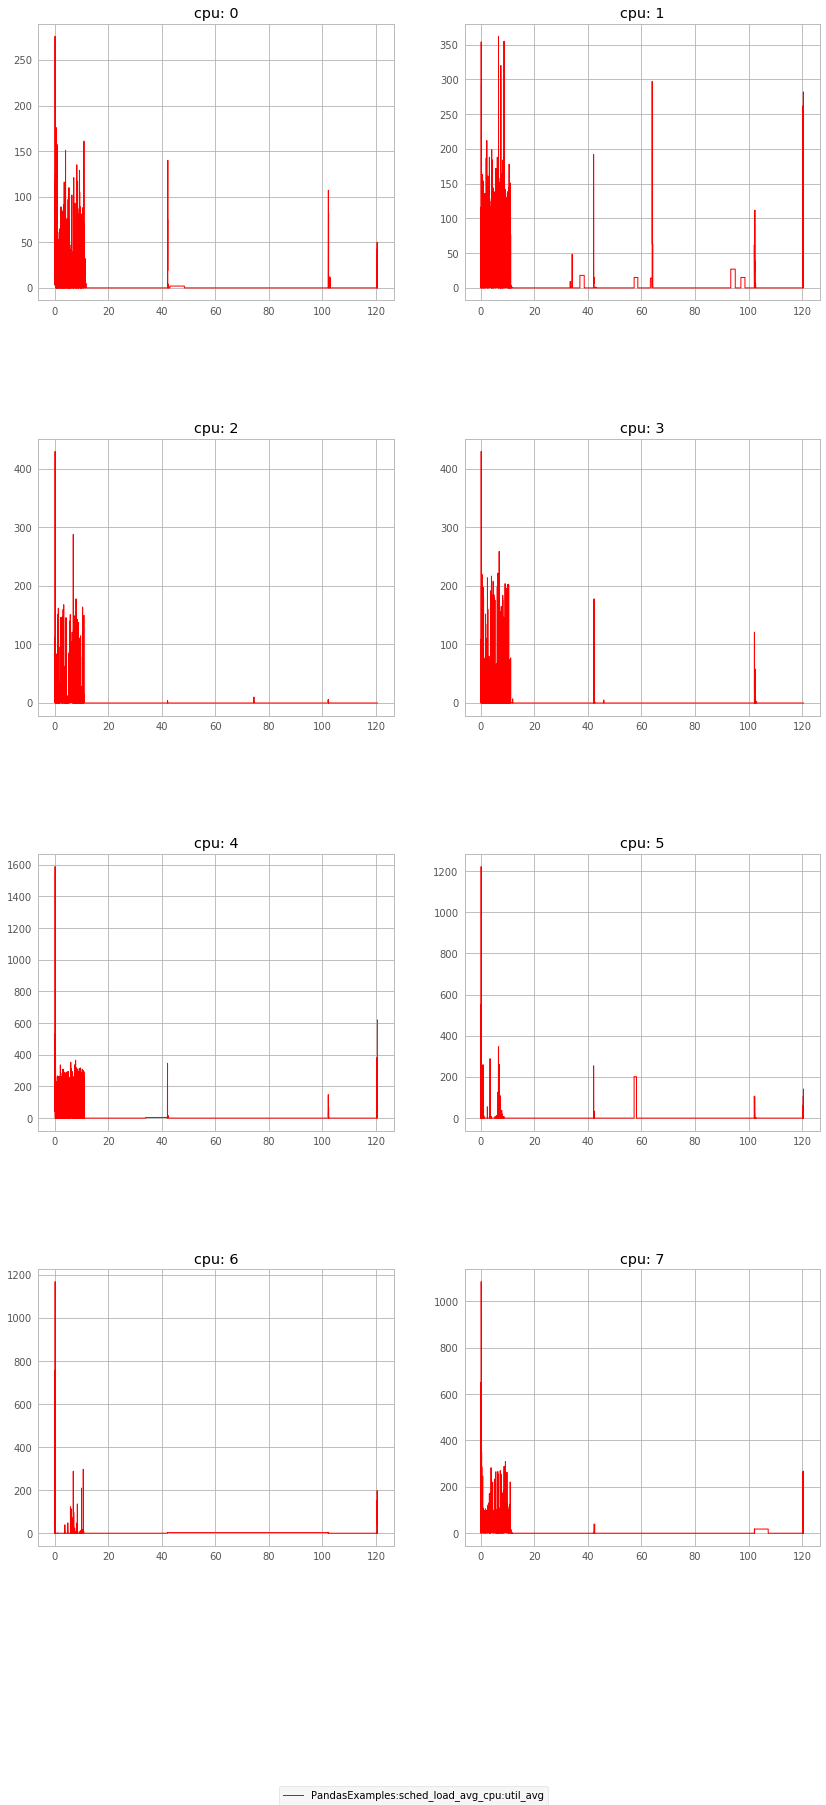

In [267]:
cpu_util_signals = [
    'sched_load_avg_cpu:util_avg',
]

res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent-state2/prev_opt/homescreen/'
trace_file = os.path.join(res_dir, "trace.dat")

ftrace = trappy.FTrace(
    name="PandasExamples",
    path=trace_file,
    scope='custom',
    events=['sched_load_avg_cpu', 'sched_switch'],
    window=(0,None))

trappy.LinePlot(
    ftrace,
    signals=cpu_util_signals,
    pivot='cpu',
    filters = {
        'cpu' : [0, 1, 2, 3, 4, 5, 6, 7]
    },
    drawstyle='steps-post',
).view()

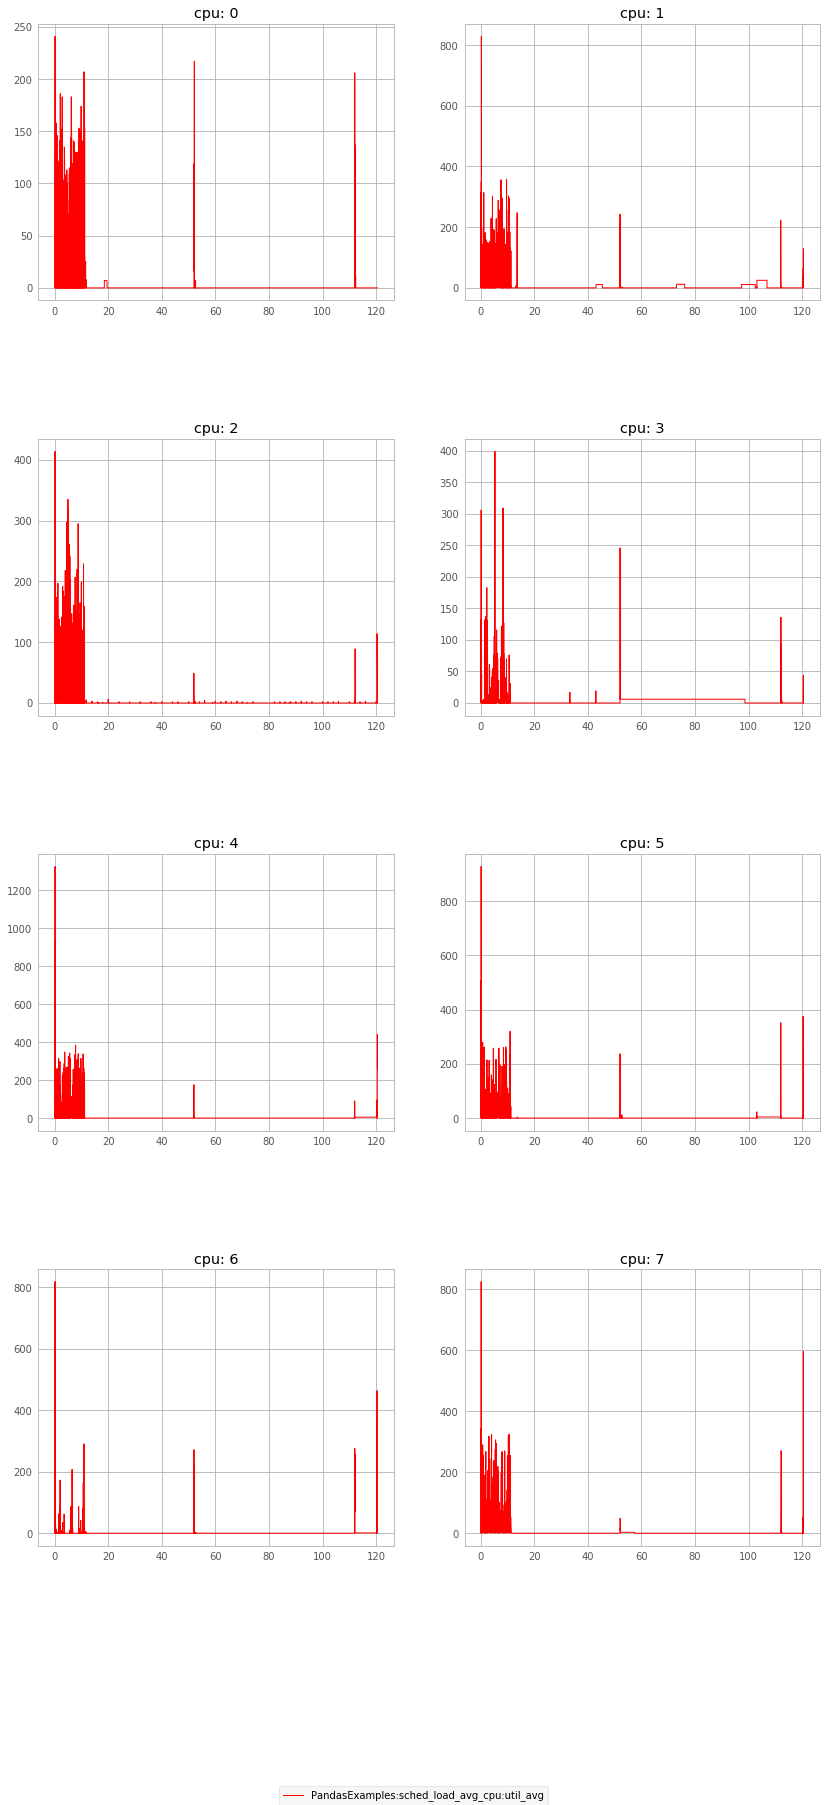

In [268]:
cpu_util_signals = [
    'sched_load_avg_cpu:util_avg',
]

res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent-state2/post_opt/homescreen/'
trace_file = os.path.join(res_dir, "trace.dat")

ftrace = trappy.FTrace(
    name="PandasExamples",
    path=trace_file,
    scope='custom',
    events=['sched_load_avg_cpu', 'sched_switch'],
    window=(0,None))

trappy.LinePlot(
    ftrace,
    signals=cpu_util_signals,
    pivot='cpu',
    filters = {
        'cpu' : [0, 1, 2, 3, 4, 5, 6, 7]
    },
    drawstyle='steps-post',
).view()

## CPUs activity comparison

In [271]:
df = prev_trace.analysis.cpus._dfg_context_switches()
df

,context_switch_cnt
cpu,
0,3060
1,4445
2,3048
3,5473
4,4043
5,712
6,569
7,4045


In [272]:
df = post_trace.analysis.cpus._dfg_context_switches()
df

,context_switch_cnt
cpu,
0,3529
1,4114
2,4476
3,2200
4,3420
5,2809
6,1125
7,3896


In [273]:
df = post_trace.analysis.cpus._dfg_context_switches() - prev_trace.analysis.cpus._dfg_context_switches()
df

,context_switch_cnt
cpu,
0,469
1,-331
2,1428
3,-3273
4,-623
5,2097
6,556
7,-149


# Energy comparison

In [270]:
def nrg_comparison(prev_csv, post_csv):
    prev_df = pd.read_csv(prev_csv, names=['id','workload','iteration','metric','value','unit'])
    post_df = pd.read_csv(post_csv, names=['id','workload','iteration','metric','value','unit'])
    
    prev_df = prev_df.drop(prev_df.index[0])
    post_df = post_df.drop(post_df.index[0])

    prev_df.value = prev_df.value.astype(float).fillna(0.0)
    post_df.value = post_df.value.astype(float).fillna(0.0)
    
    diff_df = (post_df['value'] - prev_df['value']) / (prev_df['value']) * 100
    
    print 'audio (SYS)  power: %.2f' % diff_df[5] + '%'
    print 'audio (VDD)  power: %.2f' % diff_df[6] + '%'
    print 'audio (DCIN) power: %.2f' % diff_df[7] + '%'
    print 'video (SYS)  power: %.2f' % diff_df[12] + '%'
    print 'video (VDD)  power: %.2f' % diff_df[13] + '%'
    print 'video (DCIN) power: %.2f' % diff_df[14] + '%'
    print 'homescreen (SYS)  power: %.2f' % diff_df[18] + '%'
    print 'homescreen (VDD)  power: %.2f' % diff_df[19] + '%'
    print 'homescreen (DCIN) power: %.2f' % diff_df[20] + '%'      

In [113]:
nrg_comparison('/home/leoy/Work2/Develop/test/cpuidle_loop_rework/power_data/prev_opt/results.csv',
               '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/power_data/post_opt/results.csv')

audio (SYS)  power: -9.19%
audio (VDD)  power: -29.18%
audio (DCIN) power: -26.02%
video (SYS)  power: -2.69%
video (VDD)  power: -0.77%
video (DCIN) power: 1.85%
homescreen (SYS)  power: 1.06%
homescreen (VDD)  power: -3.91%
homescreen (DCIN) power: -3.64%
